In [8]:
# benchmark_parent_filter_child_scores.py
import math
import torch
import triton
import triton.testing as tt

import sys

sys.path.append("..")

from triton_wrappers import (
    triton_three_level_filter_v1,
    triton_three_level_filter_v2,
    triton_three_level_filter_v3,
    triton_two_level_filter
)
from generate_level import generate_three_level_structure

In [9]:
# config
n = 90000
dim = 128
dtype = torch.float32
blocks = 8  # in this benchmark, BLOCK_C is set = branch
distribution = "real"
target_count = 10
device = "cuda"

### Baselines to compare

In [10]:
@torch.no_grad()
def torch_all_scores_baseline(K, q):
    scores = K @ q  # (n,)
    return scores


# v1, v2, v3

providers = {
    "three_levels_v1": triton_three_level_filter_v1,
    "three_levels_v2": triton_three_level_filter_v2,
    "three_levels_v3": triton_three_level_filter_v3,
    "two_levels": triton_two_level_filter,
    "torch_all_scores": torch_all_scores_baseline,
}

branches = {
    "three_levels_v1": 4,
    "three_levels_v2": 8,
    "three_levels_v3": 8,
    "two_levels": 8,
    "torch_all_scores": 8,
}

### Benchmark

In [11]:
def run_benchmark(n, provider, n_warps, target_count, dtype, distribution, branch):
    print(f"provider: {provider}, n: {n}")
    torch.manual_seed(0)

    K_cpu, P1_cpu, R1_cpu, P2_cpu, R2_cpu = generate_three_level_structure(
        num_keys=n,
        dim=dim,
        branching_factor=branch,
        distribution=distribution,
        seed=0,
        device="cpu",  # Generate on CPU first
    )

    # Move to GPU and convert dtype
    K = K_cpu.to(device=device, dtype=dtype)
    P1 = P1_cpu.to(device=device, dtype=dtype)
    R1 = R1_cpu.to(device=device, dtype=dtype)
    P2 = P2_cpu.to(device=device, dtype=dtype)
    R2 = R2_cpu.to(device=device, dtype=dtype)

    N_K = K.shape[0]
    N_P1 = P1.shape[0]
    N_P2 = P2.shape[0]
    B = branch
    print(N_K, N_P1, N_P2, "expect:", N_P2 * B * B, N_P2 * B)

    assert P1.shape[0] == P2.shape[0] * B, (P1.shape, P2.shape, B)
    assert K.shape[0] == P1.shape[0] * B, (K.shape, P1.shape, B)
    assert R1.shape[0] == P1.shape[0]
    assert R2.shape[0] == P2.shape[0]

    # Generate query vector
    q = torch.randn((dim,), device=device, dtype=dtype)
    q = q / (q.norm(p=2) + 1e-12)

    all_scores = K @ q
    sorted_scores, _ = torch.sort(all_scores, descending=True)
    t = sorted_scores[min(target_count, len(sorted_scores) - 1)].item()

    # output buffer (pre-zeroed each timed run)
    out = torch.zeros((N_K,), device=device, dtype=dtype)

    if (
        provider == "three_levels_v1"
        or provider == "three_levels_v2"
        or provider == "three_levels_v3"
    ):
        for _ in range(10):
            out.zero_()
            providers[provider](
                K,
                P1,
                R1,
                P2,
                R2,
                q,
                t,
                n_warps=n_warps,
                out=out,
                branch=branch,
            )
        torch.cuda.synchronize()
        out.zero_()

        def run():
            providers[provider](
                K,
                P1,
                R1,
                P2,
                R2,
                q,
                t,
                n_warps=n_warps,
                out=out,
                branch=branch,
            )

        ms = tt.do_bench(run, warmup=10, rep=100)
        return ms * 1e3
    elif provider == "torch_all_scores":
        for _ in range(10):
            _ = torch_all_scores_baseline(K, q)
        torch.cuda.synchronize()

        ms = tt.do_bench(lambda: torch_all_scores_baseline(K, q), warmup=10, rep=100)
        return ms * 1e3
    elif provider == "two_levels":
        for _ in range(10):
            out.zero_()
            providers[provider](
                K,
                P1,
                R1,
                q,
                t,
                BLOCK_C=branch,
                n_warps=n_warps,
                out=out,
                branch=branch,
            )
        torch.cuda.synchronize()
        out.zero_()

        def run():
            providers[provider](
                K,
                P1,
                R1,
                q,
                t,
                BLOCK_C=branch,
                n_warps=n_warps,
                out=out,
                branch=branch,
            )

        ms = tt.do_bench(run, warmup=10, rep=100)
        return ms * 1e3
    else:
        raise ValueError("provider must be triton or torch")

### Run

provider: three_levels_v1, n: 10000
  Loaded 10000 real keys (dimension=128)
10000 2500 625 expect: 10000 2500
provider: three_levels_v2, n: 10000
  Loaded 10000 real keys (dimension=128)
10048 1256 157 expect: 10048 1256
provider: three_levels_v3, n: 10000
  Loaded 10000 real keys (dimension=128)
10048 1256 157 expect: 10048 1256
provider: two_levels, n: 10000
  Loaded 10000 real keys (dimension=128)
10048 1256 157 expect: 10048 1256
provider: torch_all_scores, n: 10000
  Loaded 10000 real keys (dimension=128)
10048 1256 157 expect: 10048 1256
provider: three_levels_v1, n: 20000
  Loaded 20000 real keys (dimension=128)
20000 5000 1250 expect: 20000 5000
provider: three_levels_v2, n: 20000
  Loaded 20000 real keys (dimension=128)
20032 2504 313 expect: 20032 2504
provider: three_levels_v3, n: 20000
  Loaded 20000 real keys (dimension=128)
20032 2504 313 expect: 20032 2504
provider: two_levels, n: 20000
  Loaded 20000 real keys (dimension=128)
20032 2504 313 expect: 20032 2504
provider:

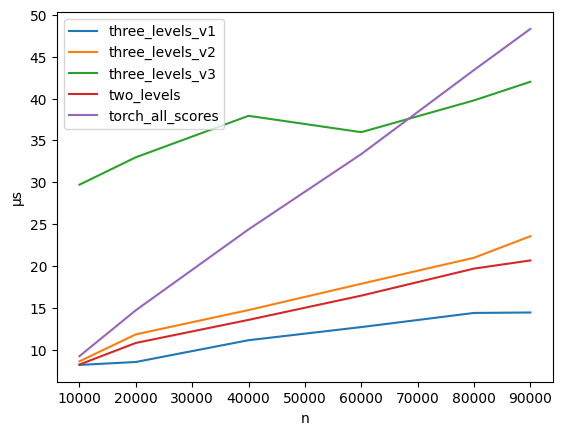

three_level_filter_real:
         n  three_levels_v1  three_levels_v2  three_levels_v3  two_levels  torch_all_scores
0  10000.0         8.159845         8.593167        29.701479    8.206032          9.207401
1  20000.0         8.510591        11.814431        32.977082   10.787388         14.696466
2  40000.0        11.113899        14.719894        37.933229   13.544636         24.360282
3  60000.0        12.682984        17.861940        35.979284   16.442162         33.360437
4  80000.0        14.373129        20.970159        39.777196   19.673127         43.407387
5  90000.0        14.426514        23.544658        42.003659   20.646367         48.320561


<Figure size 640x480 with 0 Axes>

In [12]:
line_vals = list(providers.keys())


@tt.perf_report(
    tt.Benchmark(
        x_names=["n"],
        x_vals=[10000, 20000, 40000, 60000, 80000, 90000],
        line_arg="provider",
        line_vals=line_vals,
        line_names=line_vals,
        ylabel="µs",
        plot_name=f"three_level_filter_{distribution}",
        args={
            "n_warps": 4,
            "dtype": dtype,
            "distribution": distribution,
            "target_count": target_count,
        },
    )
)
def benchmark_wrapper(n, provider, n_warps, target_count, dtype, distribution):
    return run_benchmark(
        n, provider, n_warps, target_count, dtype, distribution, branches[provider]
    )


benchmark_wrapper.run(print_data=True, show_plots=True, save_path="./reports")

### More on v1 <-> v2

provider: three_levels_v1, n: 40000
  Loaded 40000 real keys (dimension=128)
40000 20000 10000 expect: 40000 20000
provider: three_levels_v2, n: 40000
  Loaded 40000 real keys (dimension=128)
40000 20000 10000 expect: 40000 20000
provider: three_levels_v1, n: 40000
  Loaded 40000 real keys (dimension=128)
40000 10000 2500 expect: 40000 10000
provider: three_levels_v2, n: 40000
  Loaded 40000 real keys (dimension=128)
40000 10000 2500 expect: 40000 10000
provider: three_levels_v1, n: 40000
  Loaded 40000 real keys (dimension=128)
40000 5000 625 expect: 40000 5000
provider: three_levels_v2, n: 40000
  Loaded 40000 real keys (dimension=128)
40000 5000 625 expect: 40000 5000
provider: three_levels_v1, n: 40000
  Loaded 40000 real keys (dimension=128)
40192 2512 157 expect: 40192 2512
provider: three_levels_v2, n: 40000
  Loaded 40000 real keys (dimension=128)
40192 2512 157 expect: 40192 2512
provider: three_levels_v1, n: 40000
  Loaded 40000 real keys (dimension=128)
40960 1280 40 expect:

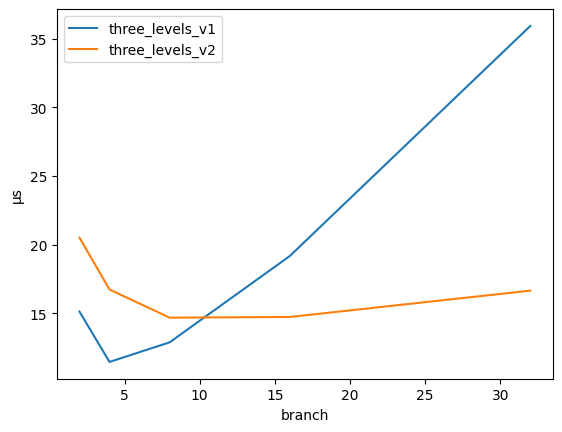

three_level_filter_real:
   branch  three_levels_v1  three_levels_v2
0     2.0        15.114901        20.506812
1     4.0        11.443954        16.721933
2     8.0        12.870952        14.669320
3    16.0        19.165680        14.720106
4    32.0        35.929765        16.637791


<Figure size 640x480 with 0 Axes>

In [ ]:
line_vals = ["three_levels_v1", "three_levels_v2"]


@tt.perf_report(
    tt.Benchmark(
        x_names=["branch"],
        x_vals=[2, 4, 8, 16, 32],
        line_arg="provider",
        line_vals=line_vals,
        line_names=line_vals,
        ylabel="µs",
        plot_name=f"three_level_filter_{distribution}",
        args={
            "n_warps": 4,
            "dtype": dtype,
            "distribution": distribution,
            "target_count": target_count,
            "n": 40000,
        },
    )
)
def benchmark_wrapper(n, provider, n_warps, target_count, dtype, distribution, branch):
    return run_benchmark(
        n, provider, n_warps, target_count, dtype, distribution, branch
    )


benchmark_wrapper.run(print_data=True, show_plots=True, save_path="./reports")